# Representation Similarity Analysis

Reference: https://github.com/markallenthornton/MIND18_RSA_tutorial

In [102]:
import numpy as np 
import pandas as pd 
from scipy.stats import multivariate_normal

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

from utils.viz import viz 
viz.get_style()

## Abstract 

## Similarity metrics

The concepts of similarity and distance are two sides of a coin, both characterizing the consistency (or inconsistency) between two measurements. There are a few quantitative metrics commonly used in statistical analysis. 

The introduction starts with applying these common metrics on a simulated data set.

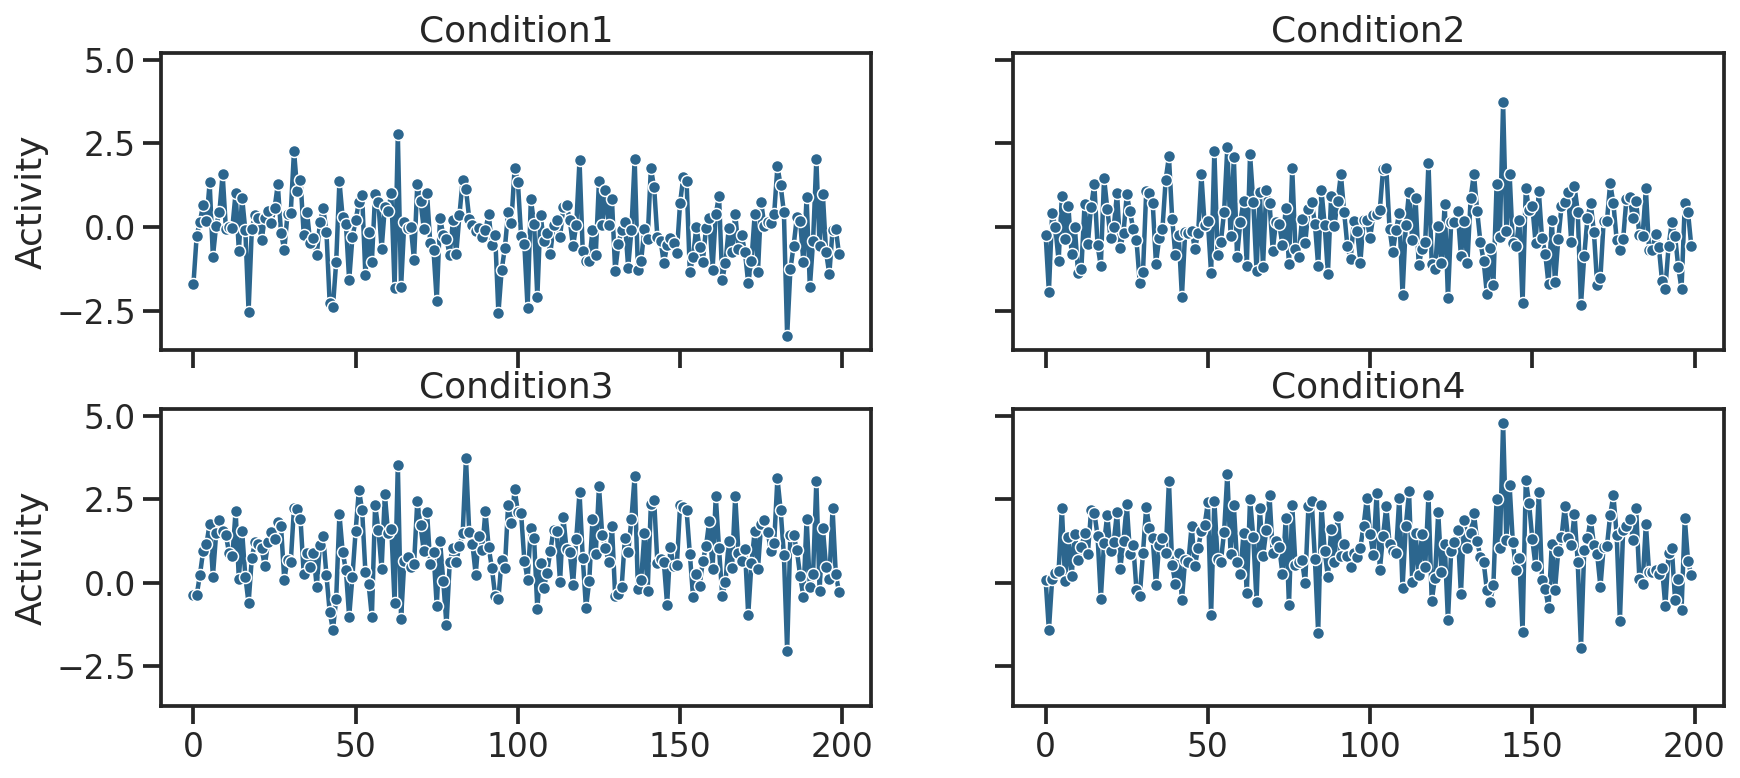

In [98]:
# generate a pseudo data set
rng = np.random.RandomState(1)
sig = np.array([1, 0,.8, 0, 
                0, 1, 0,.8,
               .8, 0, 1, 0, 
                0,.8, 0, 1]).reshape([4, 4])
data = multivariate_normal(mean=[0, 0, 1, 1], cov=sig).rvs(200, random_state=rng)

# viz the data 
nr, nc = 2, 2
fig, axs = plt.subplots(nr, nc, sharex=True, sharey=True,
                            figsize=(nr*7, nc*3))
for i in range(data.shape[1]):
    ax = axs[i//nc, i%nc]
    sns.lineplot(x=np.arange(200), y=data[:, i], marker='o',
                    markersize=6, color=viz.Blue, ax=ax)
    ax.set_ylabel('Activity')
    ax.set_title(f'Condition{i+1}')

### Mean distance

As the name suggests, the mean distance treats the mean of the measurement as the feature of each condition. So the distance between conditions is,

$$d(i,j) = \left(\frac{1}{D}\sum_{k=1}^K(x^i_d) - \frac{1}{D}\sum_{k=1}^K(x^j_d)\right)^2$$

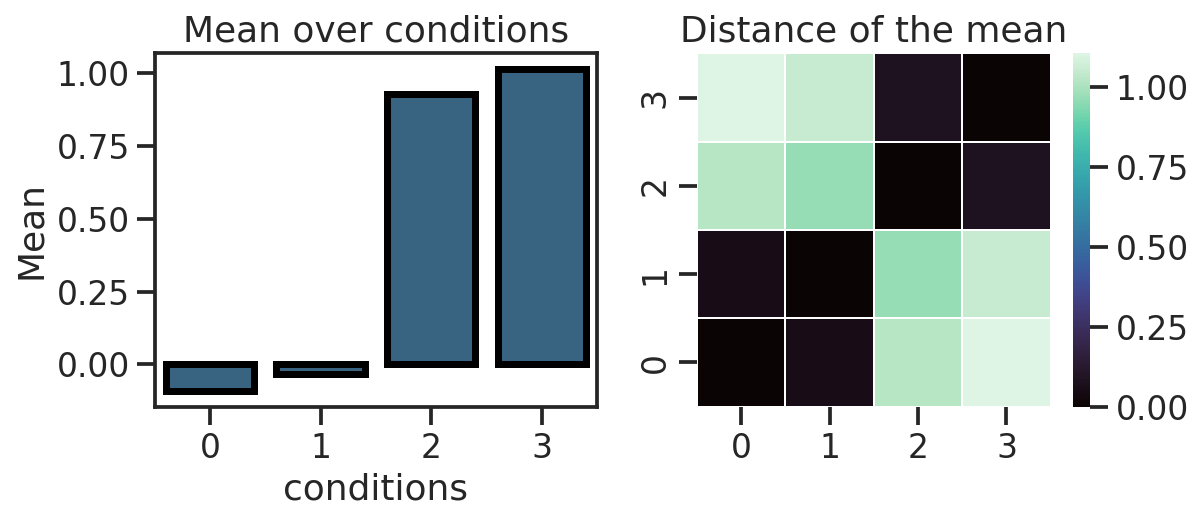

In [99]:
# get mean and distance
dmean = data.mean(0)
Dist_dmean = np.zeros([len(dmean), len(dmean)]) + np.nan
for i, m in enumerate(dmean):
    Dist_dmean[i, :] = np.sqrt((dmean - m)**2)

# viz 
nr, nc = 1, 2
fig, axs = plt.subplots(nr, nc, figsize=(nc*4.3, nr*4))
ax = axs[0]
sns.barplot(x=np.arange(4), y=dmean, lw=3.5,
            edgecolor='k', color=viz.Blue, ax=ax)
ax.set_ylabel('Mean')
ax.set_xlabel('conditions')
ax.set_title('Mean over conditions')

ax = axs[1]
sns.heatmap(data=Dist_dmean, ax=ax, lw=1, cmap='mako')
ax.invert_yaxis()
ax.set_title('Distance of the mean')


fig.tight_layout()

From the bar plot we know that the mean between pairs (0, 1) and pairs (2, 3) are close to each other. These observations are reflected on the metric distance of the mean.

### Euclidean distance

Here, we consider each data point as a feature of a condition. Thus, the euclidean distance between conditions is defined as:

$$d(i,j) = \frac{1}{K}\sum_{k=1}^K(x^i_k - x^j_k)^2$$

Text(0.5, 1.0, 'Euclidean Distance')

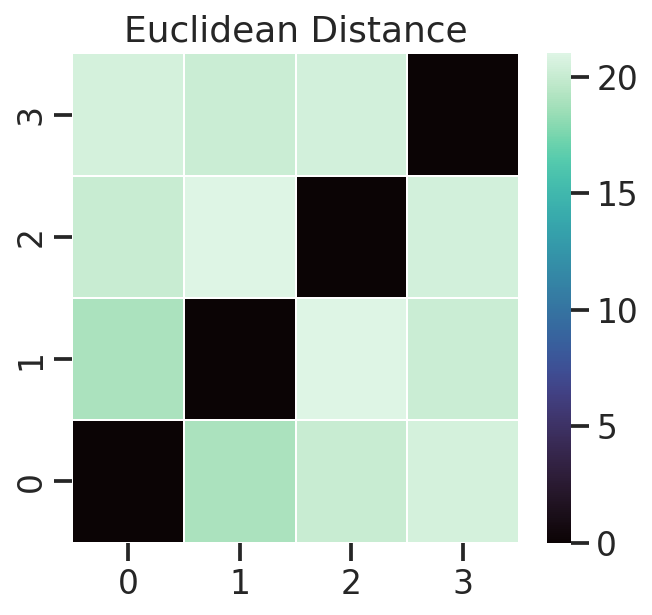

In [100]:
# transpose the data using measurement as features
data = data.reshape([4, -1])
Dist_l2 = [np.sqrt(((data-data[i, :])**2).sum(1)) for i in range(data.shape[0])]

plt.figure(figsize=(5, 4.5))
ax = sns.heatmap(data=Dist_l2, lw=1, cmap='mako')
ax.invert_yaxis()
plt.title('Euclidean Distance')

### Correlation distance 

Correlation distance only use the information in covariance matrix.

$$d(i,j) = 1-Cov(i,j)$$

Text(0.5, 1.0, 'Correlation Distance')

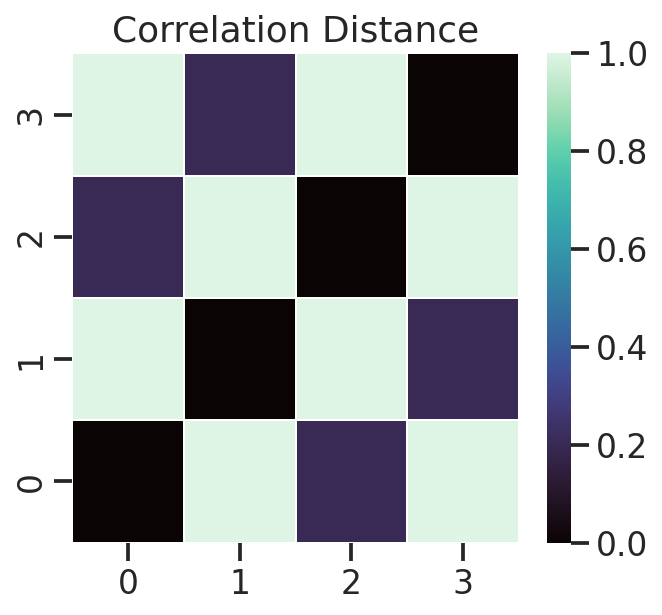

In [101]:
Dist_corr = 1 - sig 

plt.figure(figsize=(5, 4.5))
ax = sns.heatmap(data=Dist_corr, lw=1, cmap='mako')
ax.invert_yaxis()
plt.title('Correlation Distance')

## RSA tutorial: NHST, effect size, cross-validation, and model selection

In [122]:
## Load the neural data 
url = "https://github.com/markallenthornton/MIND18_RSA_tutorial/blob/master/neural_pattern_similarity.csv"
with open("url", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]
neural_data = pd.read_csv(url, sep=',',quotechar="'")

ParserError: Error tokenizing data. C error: Expected 1 fields in line 26, saw 408


In [121]:
neural_data

,<!DOCTYPE html>
0,"<html lang=""en"" data-color-mode=""auto"" data-li..."
1,<head>
2,"<meta charset=""utf-8"">"
3,"<link rel=""dns-prefetch"" href=""https://githu..."
4,"<link rel=""dns-prefetch"" href=""https://avata..."
...,...
8132,</clipboard-copy>
8133,</div>
8134,</template>
8135,</body>
